In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from multiprocessing import Pool, cpu_count
import tqdm
import random
from pathlib import Path
import torch
import robust_loss_pytorch

# functions

In [2]:
def load_data(donors):
    '''
    Loads (normalized by machine standard) raw data from a list of donors.
    Returns DataFrames in a dictionary.
    '''
    
    data = {}
    for donor in donors:
        data[donor] = pd.read_csv(f'raw_data/{donor}.csv')
    
    return data

def optimization_problem_robust_loss_production(_input):
    '''
    Uses _input list of donor_name, sampled p0, and bounds (lb, ub). Calls curve_fit() and writes out the fitted parameters.
    '''
    
    # the loss parameters alpha and scale are initially estimated as 1
    global alpha, scale, loss
    alpha, scale = 1, 1
    # reading the input
    donor, p0, lb, ub = _input
    # doing data preprocessing
    x_values, y_values, sigma = fitting_data_no_imputation(data,donor)

    # in rare cases initial parameters can lead to NaNs which can create errors. This is excepted here.
    try:
        para, var = curve_fit(f         = fit_with_sv,
                              xdata     = x_values,
                              ydata     = y_values,
                              sigma     = sigma,
                              p0        = p0,
                              bounds    = (lb.astype('float64') ,ub.astype('float64')),
                              method    = 'trf',
                              max_nfev  = 1000,
                              loss      = max_robust_loss,
                              tr_solver = 'exact')
        return [donor, list(para), float(loss)]
    except (ValueError,RuntimeError) as e:
        return '#Error'

def fitting_data_no_imputation(data,donor):
    '''
    Takes raw data dictionary and donor name.
    Parses x_values and y_values.
    Transforms y_values by calibration curve.
    Assigns 10**8 sigma values (= weights) to all 0s because they are below LOQ and thus regarded as NaNs.
    Returns x_values, sigma, y_values as float64 np.arrays.
    '''
    
    x_values = data[donor]['time'].copy()
    y_values = np.array(data[donor].loc[:,['Caffeine','Paraxanthine','Theobromine','Theophylline']].copy())
    y_values = y_values.flatten()
    
    # apply calibration curve
    calibration_k = np.array([np.ones(len(x_values))*.709,np.ones(len(x_values))*.602,np.ones(len(x_values))*.447,np.ones(len(x_values))*.564]).flatten('F')
    calibration_d = np.array([np.ones(len(x_values))*2.761,np.ones(len(x_values))*0.065,np.ones(len(x_values))*.237,np.ones(len(x_values))*.654]).flatten('F')
    y_values      = y_values*calibration_k + calibration_d

    # pharmacological factors
    vdist     = np.ones((len(x_values),4)).flatten('F')*.71  # volume of distribution of caffeine
    vsample   = 123                                          # sample volume in µL
    dose      = 200*10**3                                    # caffeine dose in µg
    avail     = .92                                          # bioavailability
    body_mass = {'Donor_16': 72, 'Donor_6': 83, 'Donor_19': 83, 'Donor_17': 52, 'Donor_18': 66, 'Donor_7': 66, 'Donor_3': 57, 'Donor_4': 84, 'Donor_5': 82.5, 'Donor_2': 77, 'Donor_8': 80, 'Donor_9': 83, 'Donor_10': 55, 'Donor_11': 54, 'Donor_1': 70, 'Donor_20': 105, 'Donor_21': 70, 'Donor_22': 64, 'Donor_23': 57, 'Donor_24': 60, 'Donor_25': 80, 'Donor_26': 86, 'Donor_27': 68, 'Donor_28': 82, 'Donor_29': 60, 'Donor_30': 55, 'Donor_31': 80, 'Donor_32': 92, 'Donor_33': 92, 'Donor_34': 71, 'Donor_35': 80, 'Donor_36': 77, 'Donor_37': 66, 'Donor_38': 63, 'Donor_39': 75, 'Donor_40': 75, 'Donor_41': 57, 'Donor_42': 75, 'Donor_43': 99, 'Donor_44': 75, 'Donor_45': 61, 'Donor_46': 52, 'Donor_47': 80}
    factor    = vsample*body_mass[donor]*vdist/(dose*avail)
    y_values  = y_values*factor
    
    # creating weights (= sigma)
    y_values_no_nan = np.nan_to_num(y_values,nan=0) 
    sigma = []
    for i in np.isnan(y_values):
        if i:
            sigma.append(10**8)
        else:
            sigma.append(1)

    return x_values.astype('float64'), y_values_no_nan.astype('float64'), np.array(sigma).astype('float64')

def save_data(output_list,filepath):
    '''
    Takes list of fitting results and file path.
    Saves fitting results row-wise in the given path.
    '''
    
    with open(filepath,'w') as file:
        for ol in output_list:
            file.write(str(ol).replace('[','').replace(']','').replace("'",'').replace(',','')+'\n')
    return

def fit_with_sv(tt,kcincaf,kcafpar,kcafbro,kcafphy,kcafdeg,kpardeg,kbrodeg,kphydeg,par0,bro0,phy0,*sfs):
    '''
    This function takes timepoints (tt) and all fitting parameters and calculates original values (c*V_sweat) with it. 
    '''
    
    # global_args and global_timepoints are needed for the calculation of relative fitting error
    global global_args, global_timepoints
    args = [kcincaf,kcafpar,kcafbro,kcafphy,kcafdeg,kpardeg,kbrodeg,kphydeg,par0,bro0,phy0]
    global_args = args
    global_timepoints = tt
    
    # sweat volumes need to be duplicated because measurements are duplicates as well
    sfs2 = np.array([sfs,sfs]).flatten('F')
    
    # calculated c*V_sweat
    caf_true = np.array(caf(tt,*args))*np.array(sfs2)
    par_true = np.array(par(tt,*args))*np.array(sfs2)
    bro_true = np.array(bro(tt,*args))*np.array(sfs2)
    phy_true = np.array(phy(tt,*args))*np.array(sfs2)
    y = np.array([caf_true,par_true,bro_true,phy_true])
    y = y.flatten('F')
    return y    

def fit_without_sv(tt,kcincaf,kcafpar,kcafbro,kcafphy,kcafdeg,kpardeg,kbrodeg,kphydeg,par0,bro0,phy0):
    '''
    This function takes timepoints and all fitting parameters and calculates concentrations (c) with it. 
    Only for single measurements per timepoint!
    '''
    args = [kcincaf,kcafpar,kcafbro,kcafphy,kcafdeg,kpardeg,kbrodeg,kphydeg,par0,bro0,phy0]
    caf_true = np.array(caf(tt,*args))
    par_true = np.array(par(tt,*args))
    bro_true = np.array(bro(tt,*args))
    phy_true = np.array(phy(tt,*args))
    y = np.array([caf_true,par_true,bro_true,phy_true])
    y = y.flatten('F')
    return y

def caf(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of caffeine.'''
    k9 = k2+k3+k4+k5
    y = k1/(k9-k1)*(np.exp(-k1*tt)-np.exp(-k9*tt))
    return y

def par(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of paraxanthine.'''
    k9 = k2+k3+k4+k5
    y = k1*k2/(k9-k1)*(np.exp(-k9*tt)/(k9-k6)-np.exp(-k1*tt)/(k1-k6)+np.exp(-k6*tt)*(k9-k1)/((k9-k6)*(k1-k6)))+par0*np.exp(-k6*tt)
    return y

def bro(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of theobromine.'''
    k9 = k2+k3+k4+k5
    y = k1*k3/(k9-k1)*(np.exp(-k9*tt)/(k9-k7)-np.exp(-k1*tt)/(k1-k7)+np.exp(-k7*tt)*(k9-k1)/((k9-k7)*(k1-k7)))+bro0*np.exp(-k7*tt)
    return y

def phy(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of theophylline.'''
    k9 = k2+k3+k4+k5
    y = k1*k4/(k9-k1)*(np.exp(-k9*tt)/(k9-k8)-np.exp(-k1*tt)/(k1-k8)+np.exp(-k8*tt)*(k9-k1)/((k9-k8)*(k1-k8)))+phy0*np.exp(-k8*tt)
    return y

def max_robust_loss(z):
    '''
    Takes array, calculates maximum of relative and absolute error and
    calculates loss with generalized adaptive loss function [1].
    
    [1] Barron, J. T. (2019). A general and adaptive robust
    loss function. In Proceedings of the IEEE/CVF Conference on Computer Vision
    and Pattern Recognition (pp. 4331-4339).
    '''
    
    global alpha, scale, loss
    # absolute error is parsed
    abs_error = z
    y = fit_without_sv(global_timepoints,*global_args)
    # calculate relative error from z
    rel_error = np.divide(z, y, out=z.copy(), where=y!=0)     # if the absolute concentration is 0 then the relative error will be set as 0
    # maximum of absolute and relative error
    z = np.maximum(abs_error,rel_error)
    
    # second optimization problem for alpha and scale, bounds are as decribed
    # in [1].(https://github.com/jonbarron/robust_loss_pytorch/blob/
    # master/robust_loss_pytorch/adaptive.py)
    result = minimize(fun=min_problem,
                      args=z,x0=(alpha,scale),
                      bounds=[(.001,1.999),(10e-5,np.inf)],
                      method='TNC',
                      options={'maxiter':100,'accuracy':10e-10})
    alpha  = result['x'][0]
    scale  = result['x'][1]
    loss   = result['fun']

    # calculate row-wise loss and gradient
    distribution = robust_loss_pytorch.distribution.Distribution()
    nll          = distribution.nllfun(torch.tensor(z,dtype=torch.float64),
                                       torch.clamp(torch.ones(1,dtype=torch.float64)*alpha,0,1.999),
                                       torch.clamp(torch.ones(1,dtype=torch.float64)*scale,0,np.inf))
    gradient     = exact_grad(z,alpha,scale)
    rho          = np.zeros((3,len(z)))
    rho[0]       = nll.detach().numpy()               # loss
    rho[1]       = gradient                           # first  derivative of loss
    # second derivative, rho[2], is not used and thus not calculated
    
    return rho

def min_problem(parameters,z):
    '''
    alpha & scale minimization problem
    '''
    alpha, scale = parameters
    distribution = robust_loss_pytorch.distribution.Distribution()
    nll  = distribution.nllfun(torch.tensor(z,dtype=torch.float64),torch.clamp(torch.ones(1,dtype=torch.float64)*alpha,0,1.999),torch.clamp(torch.ones(1,dtype=torch.float64)*scale,0,np.inf))
    
    return torch.mean(nll).detach().numpy()

def exact_grad(z,alpha,scale):
    '''Calculates robust loss gradient as described in [1], Equation 9.'''

    if alpha == 2:
        grad = z/(scale**2)
    elif alpha == 0:
        grad = 2*z/(z**2+2*scale**2)
    elif alpha == -np.inf:
        grad = z/scale**2 * np.exp(-1/2*(z/scale)**2)
    else:
        exponent = (alpha/2-1)
        grad = z/(scale**2)*((z/scale)**2/(abs(alpha-2))+1)**exponent
    return grad

# sampling for MC replicates & multiprocess fitting

In [8]:
## sampling MC replicates

# load raw data for all donors
donors = ['Donor_1', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_2', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_23', 'Donor_24', 'Donor_25', 'Donor_26', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_3', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_4', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9']
data   = load_data(donors)
# create output directory
Path('fitted_parameters').mkdir(exist_ok=True)

# generate MC replicates
input_list  = []
output_list = []

for donor in donors:
    # number of sweat volumes that are needed for fitting
    n_sf = len(data[donor].index)//2
    # calculate the normalized c(0) for C(0) = 1 mg/L for all donors
    dose      = 200*10**3    # caffeine dose
    avail     = .92          # bioavailability
    body_mass = {'Donor_16': 72, 'Donor_6': 83, 'Donor_19': 83, 'Donor_17': 52, 'Donor_18': 66, 'Donor_7': 66, 'Donor_3': 57, 'Donor_4': 84, 'Donor_5': 82.5, 'Donor_2': 77, 'Donor_8': 80, 'Donor_9': 83, 'Donor_10': 55, 'Donor_11': 54, 'Donor_1': 70, 'Donor_20': 105, 'Donor_21': 70, 'Donor_22': 64, 'Donor_23': 57, 'Donor_24': 60, 'Donor_25': 80, 'Donor_26': 86, 'Donor_27': 68, 'Donor_28': 82, 'Donor_29': 60, 'Donor_30': 55, 'Donor_31': 80, 'Donor_32': 92, 'Donor_33': 92, 'Donor_34': 71, 'Donor_35': 80, 'Donor_36': 77, 'Donor_37': 66, 'Donor_38': 63, 'Donor_39': 75, 'Donor_40': 75, 'Donor_41': 57, 'Donor_42': 75, 'Donor_43': 99, 'Donor_44': 75, 'Donor_45': 61, 'Donor_46': 52, 'Donor_47': 80}
    vdist     = .71          # specific volume of distribution for caffeine
    factor    = (body_mass[donor]*vdist*1000)/(dose*avail)
    # set system bounds
    lb = np.concatenate((np.zeros(11),np.ones(n_sf)*.05))                        # lower bounds
    ub = np.concatenate(([10],np.ones(7)*.2,np.ones(3)*factor,np.ones(n_sf)*4))  # upper bounds
    
    # sample MC replicates
    n_try   = 0
    n_tries = 100  # number of MC replicates used
    while n_try < n_tries:
        n_try += 1
        p0     = [] # initial parameters for the fit
        for l,u in zip(lb,ub):
            p0.append(random.uniform(l,u)) # sample from an uniform distribution between the system bounds
        input_list.append([donor,p0,lb,ub])

# multiprocess fitting
p = Pool(processes = cpu_count()) # by default all processors are used
err_count = 0
for _ in tqdm.tqdm(p.imap_unordered(optimization_problem_robust_loss_production,input_list),total=len(input_list)):
    if _ == '#Error':
        err_count += 1
        pass
    else:
        output_list.append(_)
p.close()
print('Error Percentage {:2.2f}'.format(err_count/len(input_list)))

# safe the results
for donor in donors:
    write_out = []
    for i in output_list:
        if i[0] == donor:
            write_out.append(i[1:])
    save_data(write_out,f'fitted_parameters/{donor}.txt')

100%|██████████| 4100/4100 [30:21<00:00,  2.25it/s]  

Error Percentage 0.00


# parse results

In [4]:
# parameter properties
parameter_names = ['k1','k2','k3','k4','k5','k6','k7','k8','cpar0','cbro0','cphy0','vsweat1','vsweat2','vsweat3','vsweat4','vsweat5','vsweat6','vsweat7','vsweat8','vsweat9','vsweat10','vsweat11','vsweat12','vsweat13','vsweat14','vsweat15','vsweat16','vsweat17','vsweat18','vsweat19','vsweat20','vsweat21','vsweat22','vsweat23','vsweat24']
parameter_units = ['[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[unitless]','[unitless]','[unitless]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]']

# load raw data for all donors
donors = ['Donor_1', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_2', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_23', 'Donor_24', 'Donor_25', 'Donor_26', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_3', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_4', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9']
data   = load_data(donors)

best_parameters = {}
for donor in donors:  
    # read in file
    with open(f'./fitted_parameters/{donor}.txt','r') as file:
        lines  = file.readlines()
    parameters = []
    losses     = []
    for line in lines:
        tmp = []
        for l in line.split()[0:-1]:
            tmp.append(float(l))
        parameters.append(tmp)
        losses.append(float(line.split()[-1]))
    
    # select fit with lowest loss
    best = parameters[np.argmin(losses)]
    best_parameters[donor] = best
   
    # write out donor-wise results
    print('--------',donor,'--------')
    for value, name, unit in zip(best,parameter_names,parameter_units):
            print('{:15} {:0.3f} {:5} '.format(name,round(value,6),unit))
    

-------- Donor_1 --------
k1              5.317 [h-1] 
k2              0.032 [h-1] 
k3              0.008 [h-1] 
k4              0.003 [h-1] 
k5              0.014 [h-1] 
k6              0.192 [h-1] 
k7              0.123 [h-1] 
k8              0.049 [h-1] 
cpar0           0.019 [unitless] 
cbro0           0.020 [unitless] 
cphy0           0.029 [unitless] 
vsweat1         0.733 [µL]  
vsweat2         1.778 [µL]  
vsweat3         0.964 [µL]  
vsweat4         0.987 [µL]  
vsweat5         1.161 [µL]  
vsweat6         0.917 [µL]  
vsweat7         1.004 [µL]  
vsweat8         1.028 [µL]  
vsweat9         1.154 [µL]  
vsweat10        1.215 [µL]  
vsweat11        1.577 [µL]  
vsweat12        1.422 [µL]  
vsweat13        1.035 [µL]  
vsweat14        1.179 [µL]  
vsweat15        2.711 [µL]  
-------- Donor_10 --------
k1              2.504 [h-1] 
k2              0.028 [h-1] 
k3              0.007 [h-1] 
k4              0.006 [h-1] 
k5              0.012 [h-1] 
k6              0.200 [h-1] 
k7  

# plot results

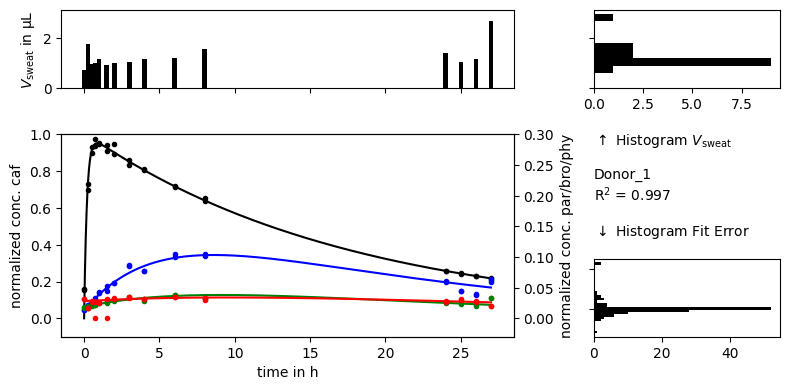

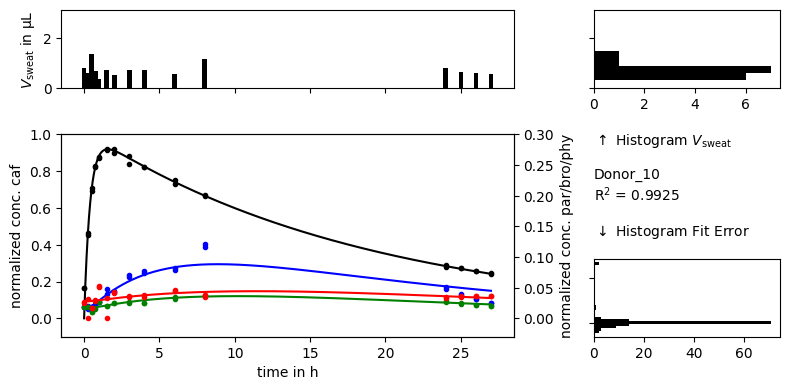

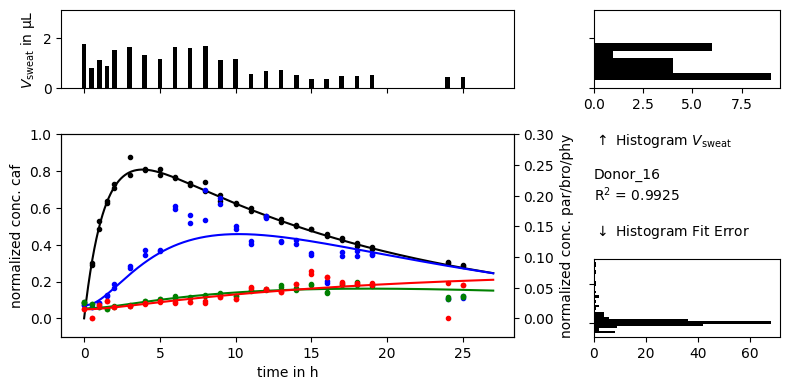

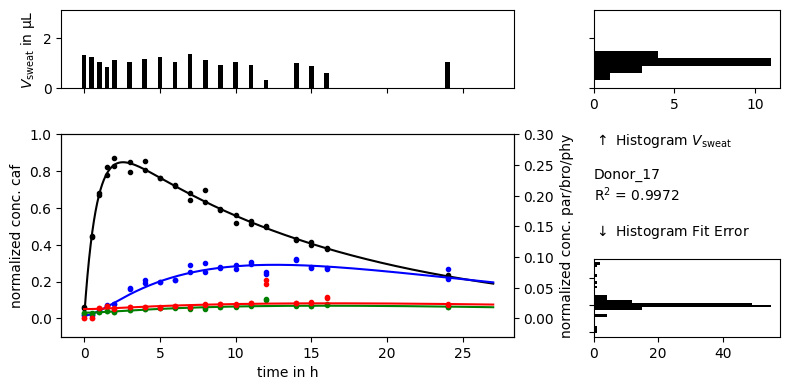

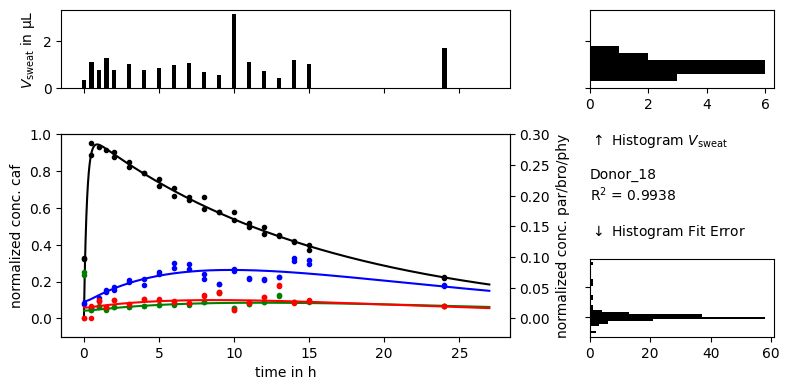

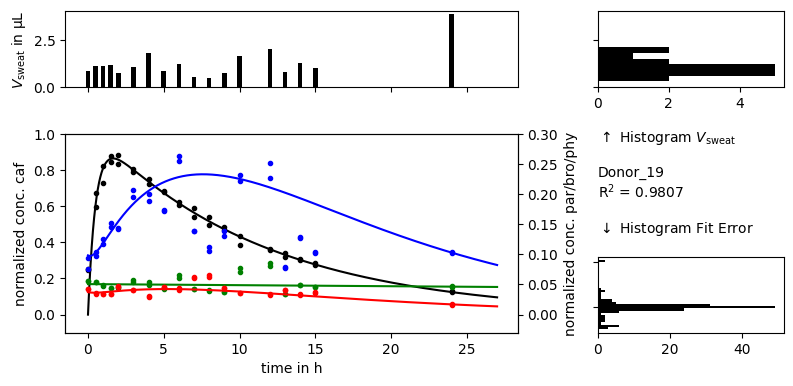

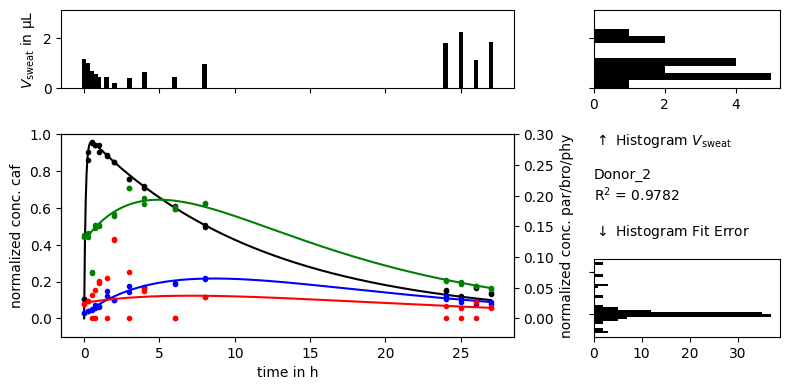

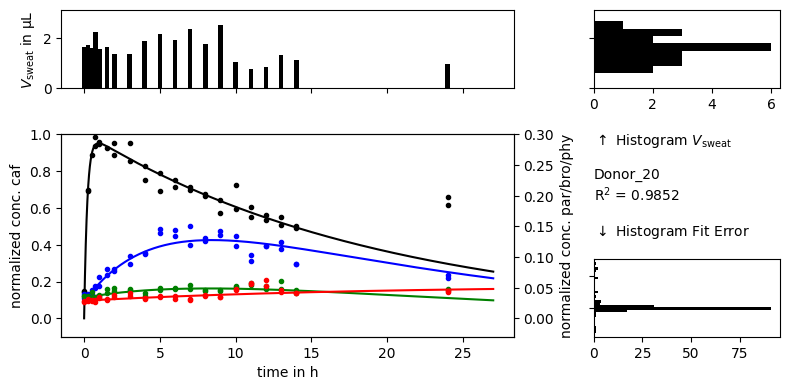

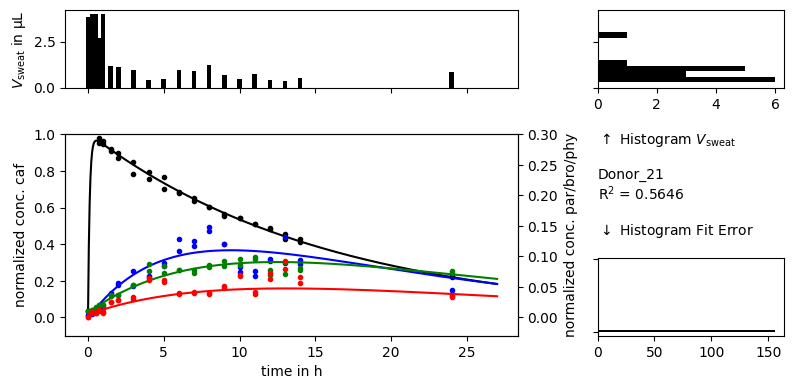

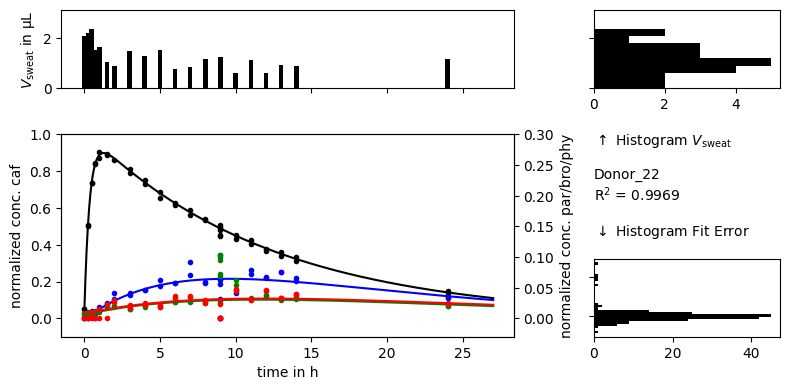

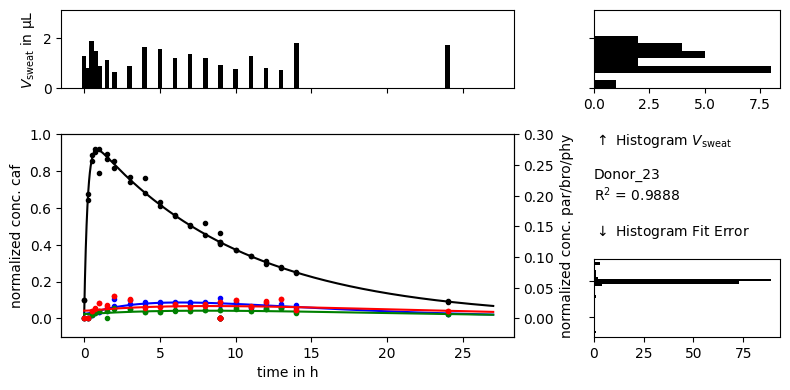

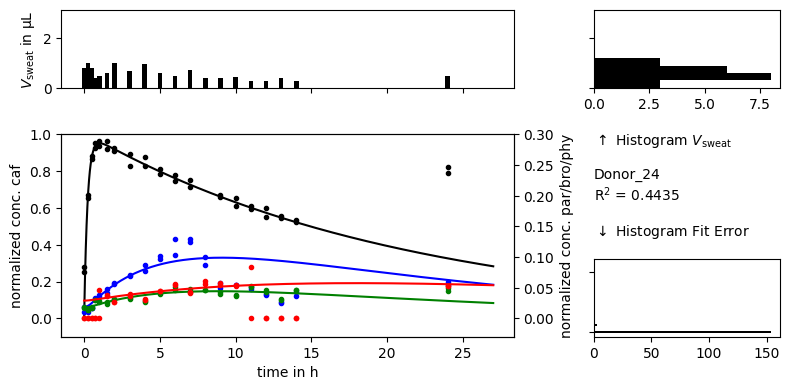

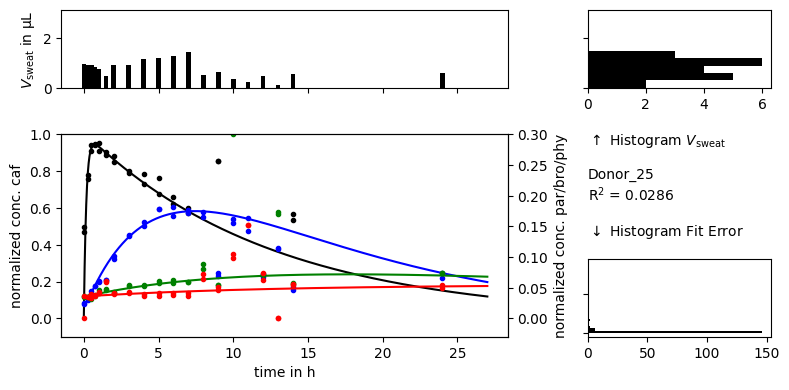

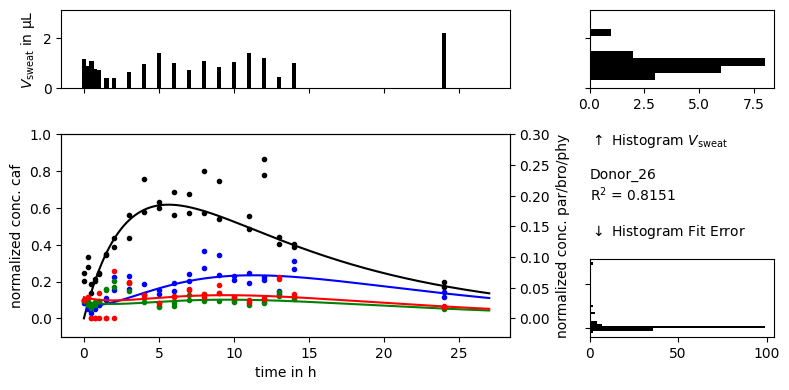

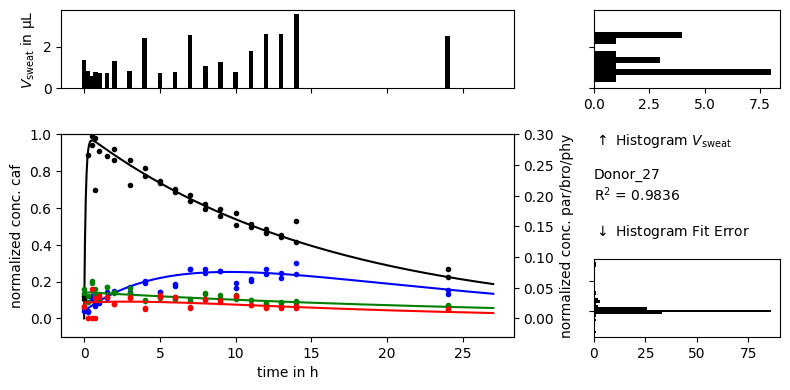

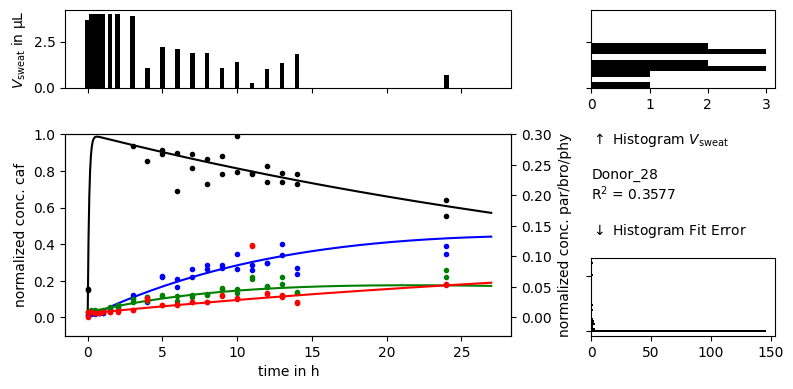

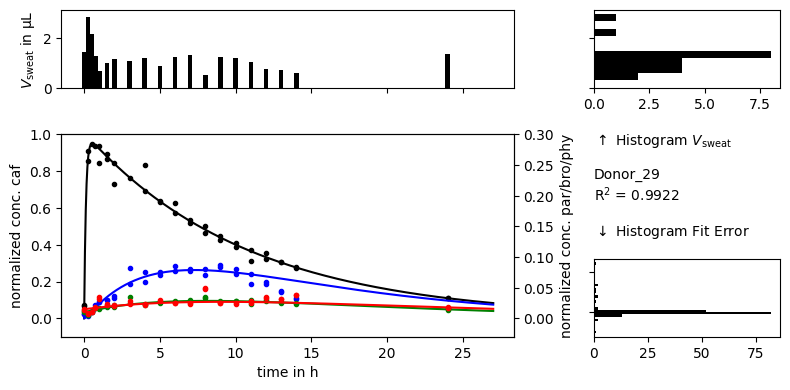

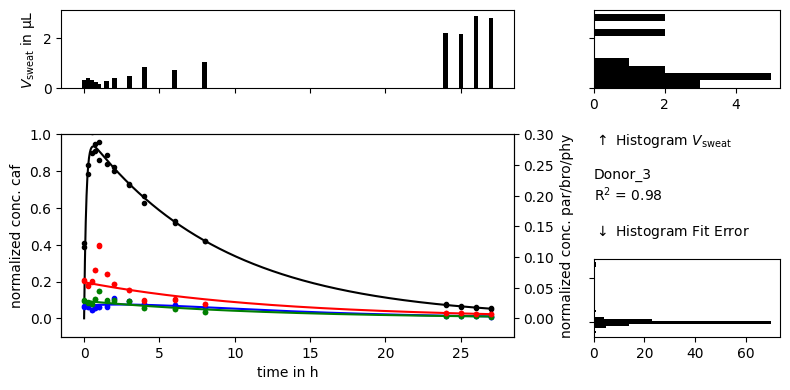

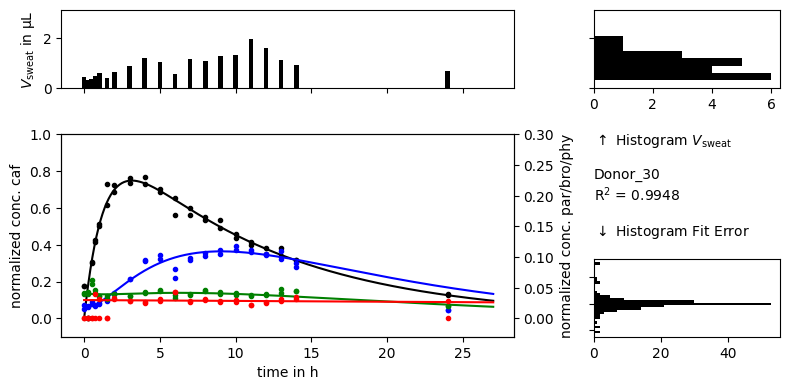

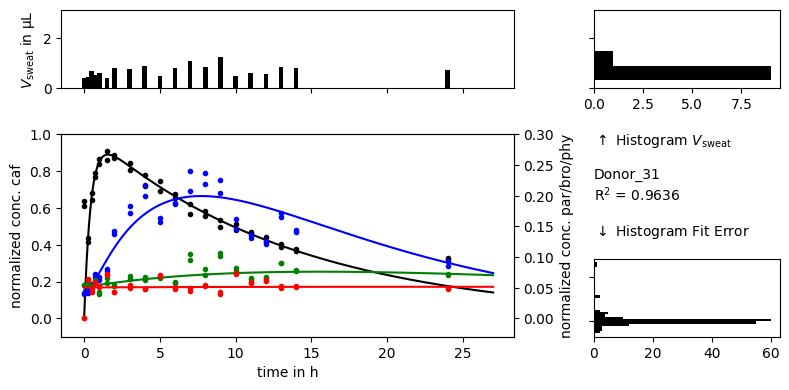

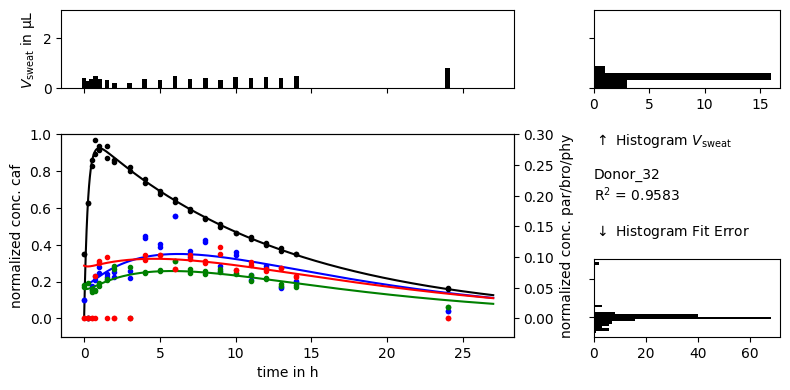

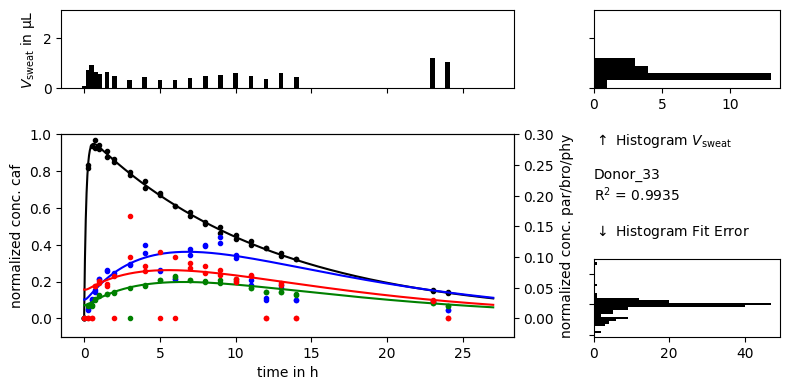

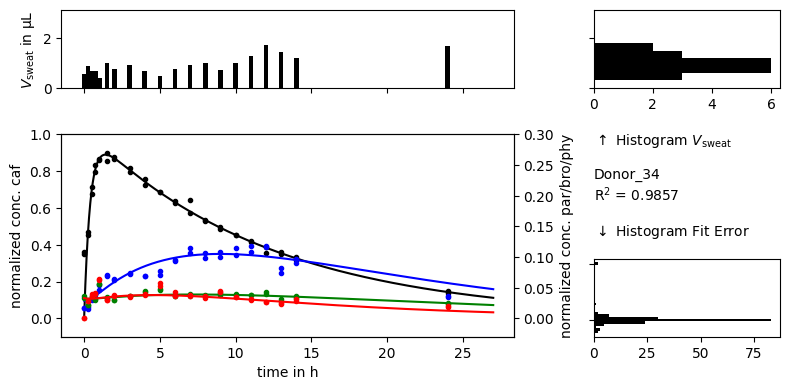

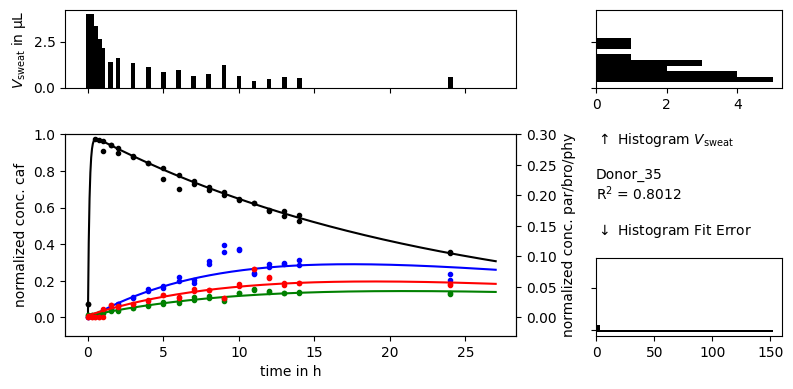

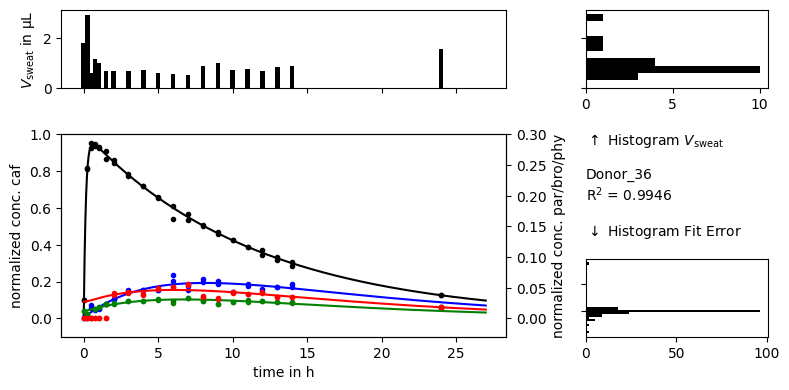

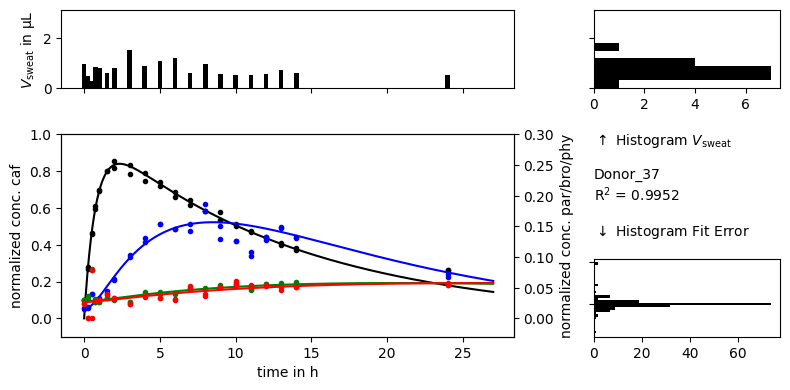

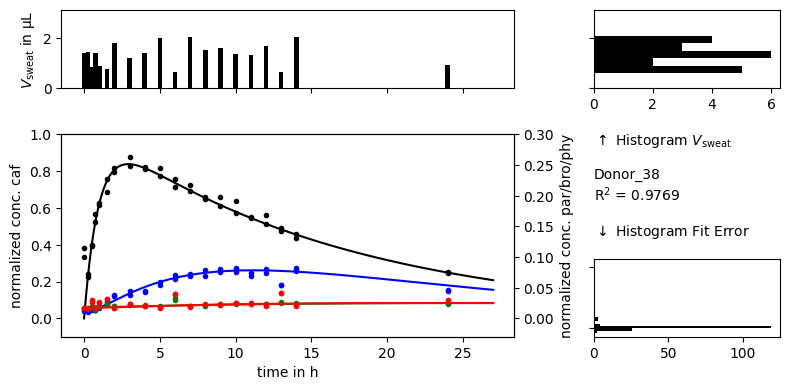

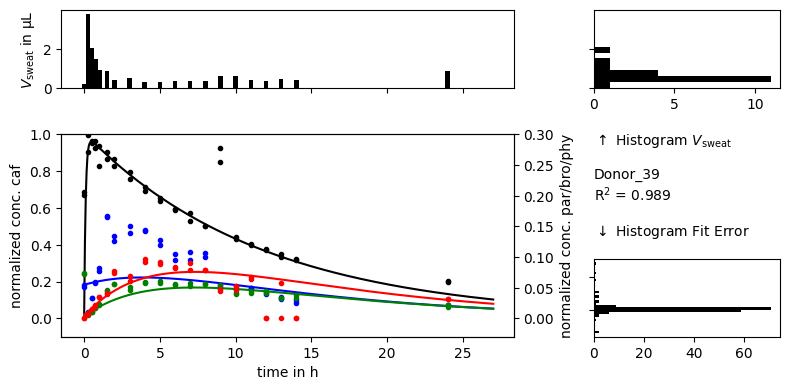

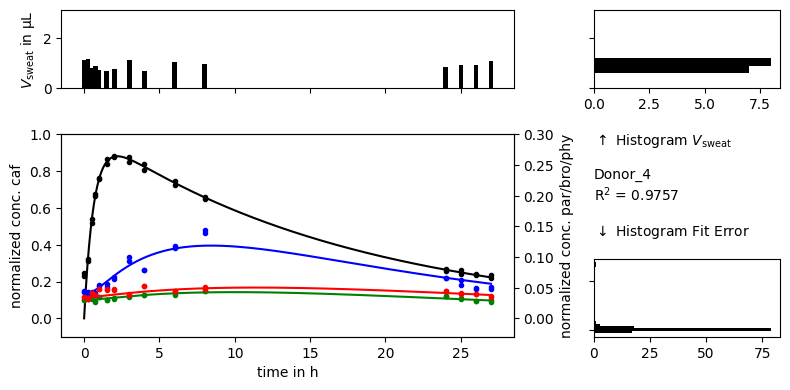

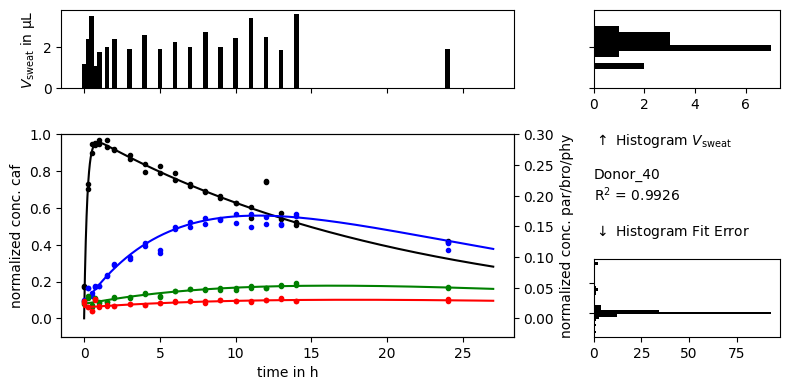

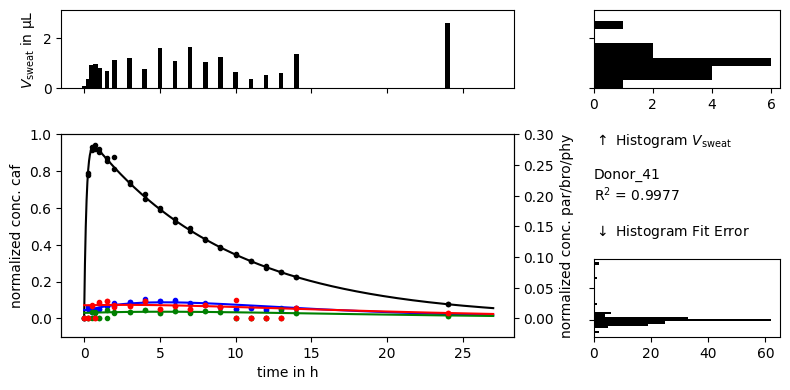

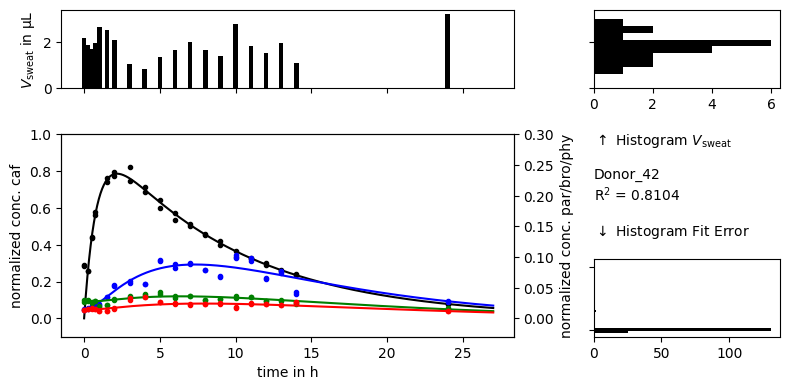

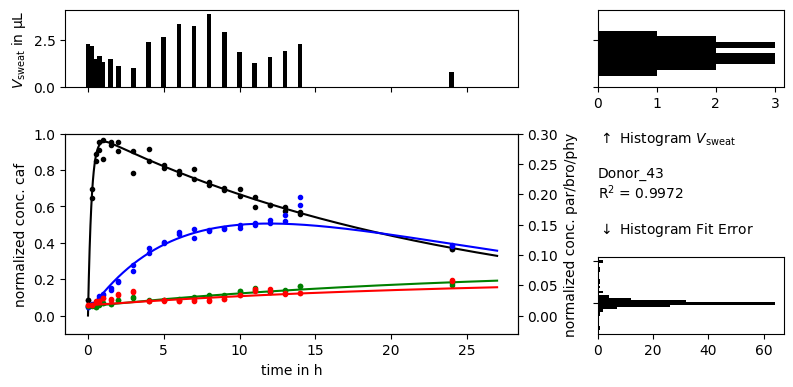

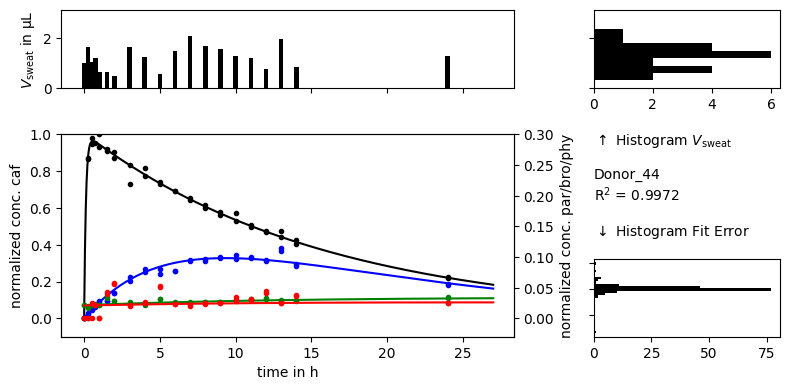

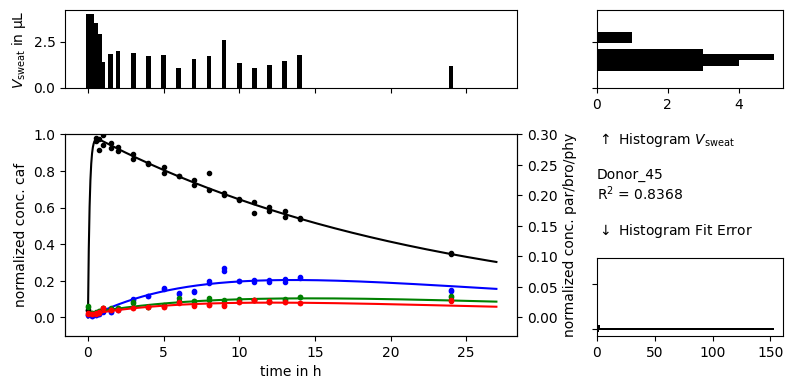

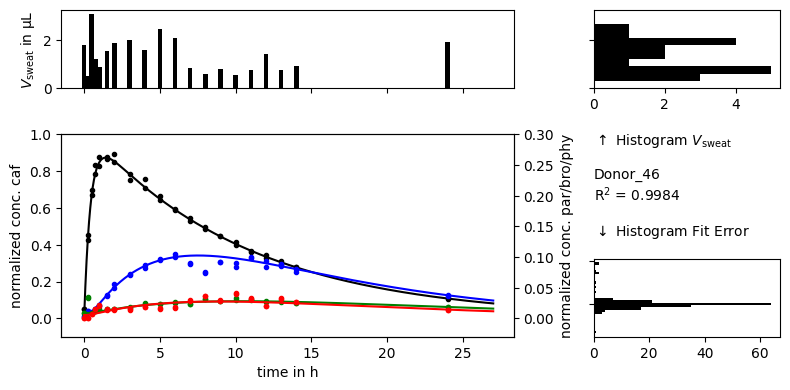

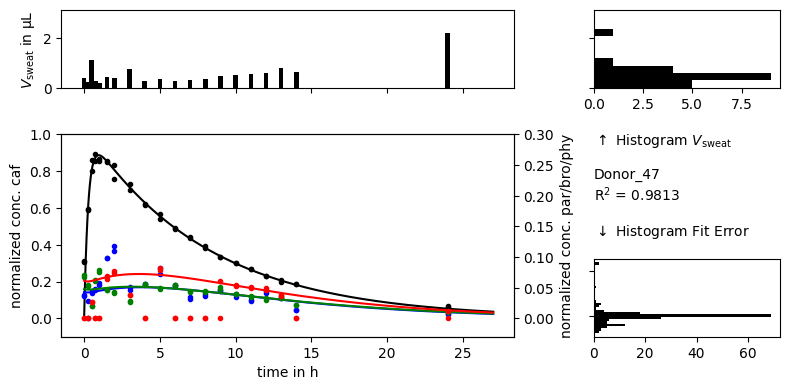

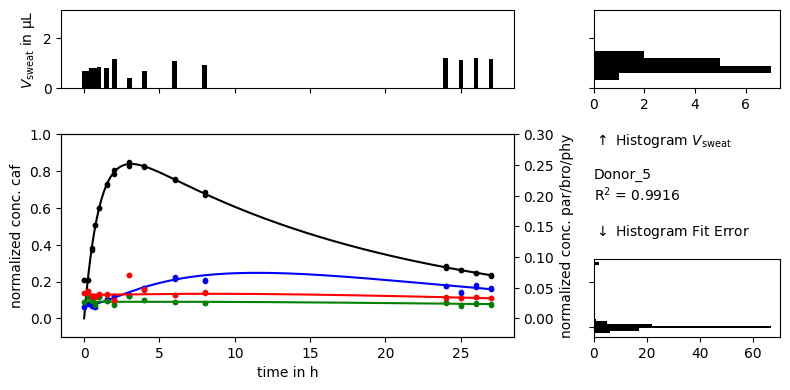

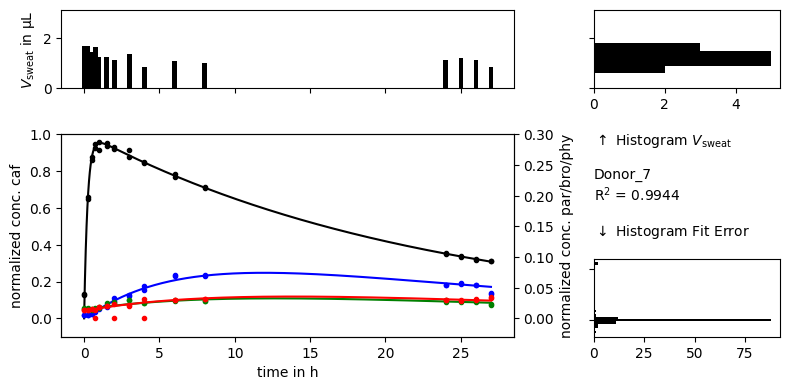

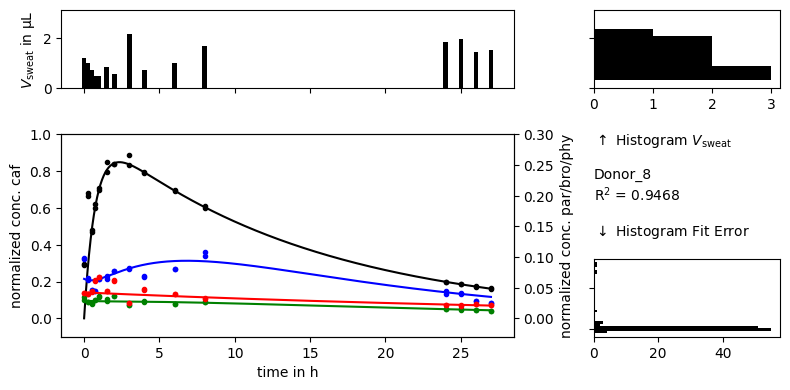

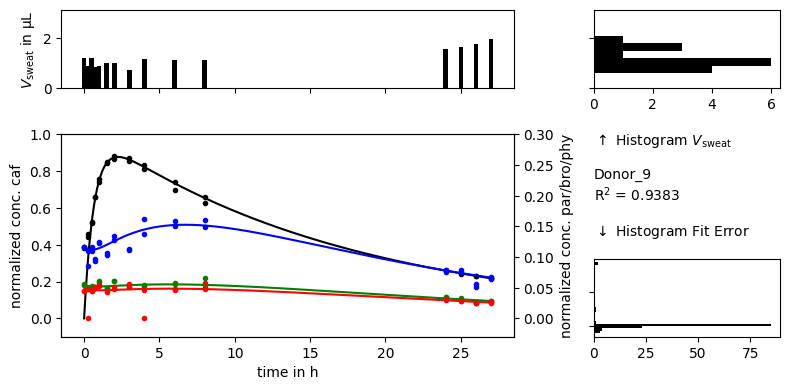

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_fit(best, donor, data):
    # get measured values
    x_values, y_values,s = fitting_data_no_imputation(data,donor)
    # get best parameters for that donor
    args = best[:11]
    sv = np.array(best[11:])
    sv2 = np.array([sv,sv]).flatten('F')
    
    # begin figure
    fig = plt.figure(dpi=100,figsize=(8,4))
    gs  = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[1:, :2])
    ax1.set_ylabel('normalized conc. caf')
    ax1.set_xlabel('time in h')
    ax2 = plt.twinx(ax1)
    ax2.set_ylabel('normalized conc. par/bro/phy')
    #caf
    ax1.plot(np.linspace(0,27,1000),caf(np.linspace(0,27,1000),*args),'k')
    ax1.plot(x_values,y_values[0::4]/sv2,'k.')
    #par
    ax2.plot(np.linspace(0,27,1000),par(np.linspace(0,27,1000),*args),'b')
    ax2.plot(x_values,y_values[1::4]/sv2,'b.')
    #bro
    ax2.plot(np.linspace(0,27,1000),bro(np.linspace(0,27,1000),*args),'g')
    ax2.plot(x_values,y_values[2::4]/sv2,'g.')
    #phy
    ax2.plot(np.linspace(0,27,1000),phy(np.linspace(0,27,1000),*args),'r')
    ax2.plot(x_values,y_values[3::4]/sv2,'r.')
    ax1.set_ylim(-.1,1)
    ax2.set_ylim(-.03,.3)

    # calculate adjusted R2
    # R2adj = 1 - (1-R2) * (n-1)/(n-p)
    observed = y_values
    expected = np.array([caf(x_values,*args)*sv2,par(x_values,*args)*sv2,bro(x_values,*args)*sv2,phy(x_values,*args)*sv2]).flatten('F')
    sstot    = np.sum((observed-np.mean(observed))**2)
    ssres    = np.sum((observed-expected)**2)
    r2       = 1-ssres/sstot
    
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.text(0,-.3,r'$\uparrow$ Histogram $V_{\rm sweat}$'+'\n\n'+donor+'\n'+r'R$^2$ = '+str(round(r2,4))+'\n\n'+r'$\downarrow$ Histogram Fit Error')
    ax6.set_xlabel('time')
    
    ax3 = fig.add_subplot(gs[0, :2],sharex=ax1)
    ax3.bar(x_values[0::2][:len(sv)],sv,.3,color='k')
    ax3.set_ylabel(r'$V_{\rm sweat}$ in µL')
    ax3.tick_params(labelbottom=False)
    ax4 = fig.add_subplot(gs[0, 2:],sharey=ax3)
    ax4.hist(sv,bins=10,range=(0,3),histtype='stepfilled',color='k',orientation='horizontal')
    ax4.tick_params(labelleft=False)
    ax5 = fig.add_subplot(gs[2:, 2:])
    ax5.hist(observed-expected,bins=30,histtype='stepfilled',color='k',orientation='horizontal')
    ax5.tick_params(labelleft=False)
    ax6.tick_params(labelleft=False,labelbottom=False)
    ax6.axis('off')
    
    plt.tight_layout()
    plt.show()
    return 

data = load_data(donors)

for donor in donors:
    plot_fit(best_parameters[donor],donor,data)
